In [179]:
import yfinance as yf
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

##N-BEATS


In [180]:
input_size = 10
backcast_length = 10
forecast_length = 5
hidden_units = 128
num_blocks = 4
num_layers = 4

In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self,
                  input_size: int,
                  backcast_length: int,
                  forecast_length: int,
                  hidden_units: int,
                  hidden_layers: int):
        super(Block, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
    
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(nn.ReLU())
            input_size = hidden_units
        layers.append(nn.Linear( hidden_units, backcast_length + forecast_length))
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        y = self.model(x)
        y_1d = y.squeeze()
        backcast, forecast =torch.split(y_1d, [self.backcast_length, self.forecast_length], dim=0)
        return backcast, forecast
    
class NbeatsStack(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 ):
        super(NbeatsStack, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        self.blocks = nn.ModuleList([Block(input_size, backcast_length, forecast_length, hidden_units, hidden_layers) for _ in range(num_blocks)])
    
    def forward(self, x):
        backcasts = []
        forecasts = []
        for block in self.blocks:
            backcast, forecast = block(x)
            backcasts.append(backcast.unsqueeze(1))
            forecasts.append(forecast.unsqueeze(1))
            x = torch.cat([x.squeeze(), backcast.unsqueeze(1).squeeze()], dim=0)

            backcasts = torch.cat(backcasts, dim=1)
            forecasts = torch.cat(forecasts, dim=1)
            return backcasts, forecasts

##Get Data

In [182]:
GetFacebookInformation = yf.Ticker("META")
facebook_history = GetFacebookInformation.history(period="max")
print(facebook_history)


                                 Open        High         Low       Close  \
Date                                                                        
2012-05-18 00:00:00-04:00   42.049999   45.000000   38.000000   38.230000   
2012-05-21 00:00:00-04:00   36.529999   36.660000   33.000000   34.029999   
2012-05-22 00:00:00-04:00   32.610001   33.590000   30.940001   31.000000   
2012-05-23 00:00:00-04:00   31.370001   32.500000   31.360001   32.000000   
2012-05-24 00:00:00-04:00   32.950001   33.209999   31.770000   33.029999   
...                               ...         ...         ...         ...   
2024-02-13 00:00:00-05:00  456.869995  467.890015  455.089996  460.119995   
2024-02-14 00:00:00-05:00  467.929993  474.109985  466.089996  473.279999   
2024-02-15 00:00:00-05:00  475.279999  488.619995  472.220001  484.029999   
2024-02-16 00:00:00-05:00  478.109985  478.959991  469.209991  473.320007   
2024-02-20 00:00:00-05:00  469.720001  476.179993  466.559998  471.750000   

In [183]:
train_data_set = facebook_history[:2800]
test_data_set = facebook_history[2800:]

In [184]:
#x_train = []
#y_train = []
#for i in range(backcast_length, len(train_data_set) - forecast_length):
#    x_res = []
#    for b in range(backcast_length):
#        x_res.append(train_data_set.iloc[i - backcast_length + b, 1].tolist())
#    x_train.append(x_res)
#
#    y_res = []
#    for f in range(forecast_length):
#        y_res.append(train_data_set.iloc[i + f, 1].tolist())
#    y_train.append(y_res)

In [196]:
#Pre-process data
def pre_process(dataset, backcast, forecast):
    x_l = []
    y_l = []

    for i in range(backcast, len(dataset) - forecast):
        x = []
        for b in range(backcast):
            x.append(dataset.iloc[i - backcast + b, 1].tolist())
        x_l.append(x)

        y = []
        for f in range(forecast_length):
            y.append(dataset.iloc[i + f, 1].tolist())
        y_l.append(y)

    return x_l,y_l

x_train, y_train = pre_process(train_data_set, backcast_length, forecast_length)
x_test, y_test = pre_process(test_data_set, backcast_length, forecast_length)


In [197]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

[[45.0, 36.65999984741211, 33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273], [36.65999984741211, 33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273], [33.59000015258789, 32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836], [32.5, 33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836, 27.170000076293945], [33.209999084472656, 32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000076293945, 29.149999618530273, 27.649999618530273, 27.760000228881836, 27.170000076293945, 27.350000381469727], [32.95000076293945, 31.690000534057617, 29.549999237060547, 29.670000

##Define model


In [216]:
model = NbeatsStack(input_size,
                    backcast_length,
                    forecast_length,
                    hidden_units,
                    num_layers,
                    num_blocks)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

NbeatsStack(
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (model): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=15, bias=True)
      )
    )
  )
)


In [217]:
##Train
num_epochs = 1
train_outputs = []
for epoch in range(num_epochs):
    model.train()
    for i in range(len(x_train)):
        x = torch.Tensor(x_train[i])
        y = torch.Tensor(y_train[i])
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
        train_outputs.append(forecasts.squeeze().tolist()[0])
        loss = criterion(forecasts.squeeze(), y)
        loss.backward()
        optimizer.step()
    print(epoch)
    

        

0


In [218]:
print(train_outputs)


[0.07560162246227264, 7.868396282196045, 37.37282180786133, 27.07986831665039, 20.137941360473633, 23.186010360717773, 30.430200576782227, 30.95619773864746, 28.454559326171875, 29.136714935302734, 32.40300369262695, 32.39075469970703, 29.57603645324707, 30.16783905029297, 34.43229293823242, 36.25740432739258, 32.57776641845703, 31.333656311035156, 33.816219329833984, 35.03964614868164, 31.268796920776367, 28.80963897705078, 30.157073974609375, 32.329559326171875, 31.07550811767578, 30.23434829711914, 31.586639404296875, 33.3625602722168, 33.35295486450195, 31.61326789855957, 29.752216339111328, 28.453821182250977, 29.140405654907227, 29.639171600341797, 27.785078048706055, 24.957412719726562, 24.976837158203125, 27.37777328491211, 28.546457290649414, 26.0504207611084, 23.872053146362305, 23.4822940826416, 23.862512588500977, 23.688737869262695, 23.486316680908203, 22.651336669921875, 20.46607780456543, 18.21298599243164, 18.042274475097656, 19.410825729370117, 20.667011260986328, 20.4

[27.649999618530273, 27.760000228881836, 27.170000076293945, 27.350000381469727, 27.760000228881836, 28.06999969482422, 27.770000457763672, 28.100000381469727, 28.31999969482422, 30.100000381469727, 32.08000183105469, 32.18000030517578, 31.93000030517578, 32.5, 33.45000076293945, 33.02000045776367, 33.439998626708984, 32.900001525878906, 32.189998626708984, 31.989999771118164, 31.729999542236328, 31.440000534057617, 31.6299991607666, 31.899999618530273, 32.880001068115234, 32.47999954223633, 31.559999465942383, 31.399999618530273, 31.06999969482422, 30.5, 28.59000015258789, 29.290000915527344, 29.5, 29.469999313354492, 29.0, 29.450000762939453, 29.489999771118164, 28.229999542236328, 24.540000915527344, 24.040000915527344, 23.3700008392334, 21.579999923706055, 20.84000015258789, 22.15999984741211, 22.149999618530273, 22.450000762939453, 21.149999618530273, 21.170000076293945, 21.81999969482422, 22.450000762939453, 21.600000381469727, 21.40999984741211, 20.479999542236328, 20.0799999237

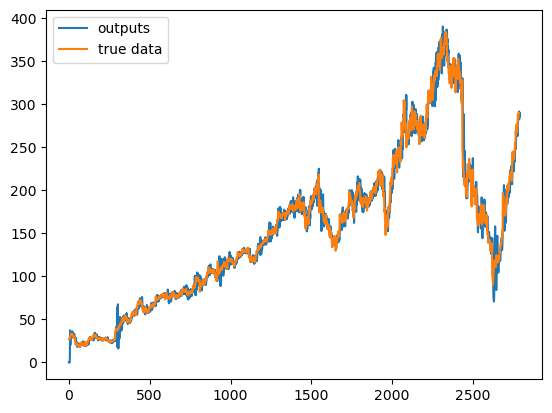

In [223]:
### PLOT TRAIN DATA

import matplotlib.pyplot as plt
backcast, forecast = model(torch.Tensor(x_train[1]))

bc = backcast.squeeze().tolist()
fc = forecast.squeeze().tolist()
pred = bc + fc

actual = x_train[1] + y_train[1]

yyy = [x[0] for x in y_train]
print(yyy)
print(train_outputs[:2800])

plt.plot([0,0,0,0,0] + train_outputs[:2800], label="outputs")

plt.plot(yyy, label="true data")
plt.legend()


In [220]:
##Eval
outputs = []

outputs.append()
model.eval()

with torch.no_grad():
    #for i in range(len(x_test)):
    #    inp = torch.Tensor(x_test[i])
    #    print(inp)
    #    backcast, for_c = model(inp)
    #    print(backcast)
    #    print(for_c)
    #    outputs.append(for_c.squeeze().tolist()[0])

    for i in range(len(x_test)):
        x = torch.Tensor(x_test[i])
        y = torch.Tensor(y_test[i])
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
        outputs.append(forecasts.squeeze().tolist()[0])

yyy_test = [x[0] for x in y_test]
print(len(yyy_test))


142


[308.0904846191406, 309.652587890625, 309.0790710449219, 309.18798828125, 309.9390869140625, 310.4714050292969, 310.5068359375, 310.8817138671875, 310.12506103515625, 309.44183349609375, 311.7186584472656, 313.87774658203125, 315.6346435546875, 318.18548583984375, 319.69927978515625, 317.99578857421875, 316.5218505859375, 314.7679443359375, 312.9709167480469, 311.8585510253906, 310.2316589355469, 306.5976867675781, 303.83984375, 302.05426025390625, 300.6114501953125, 298.3792724609375, 295.9421081542969, 293.9949951171875, 292.7464294433594, 293.4085998535156, 294.3446044921875, 294.1603088378906, 294.69073486328125, 296.92669677734375, 297.6512145996094, 297.96484375, 300.1478271484375, 301.601806640625, 302.602294921875, 304.138427734375, 305.00390625, 306.04754638671875, 306.372802734375, 306.152099609375, 307.0963134765625, 307.56549072265625, 305.48297119140625, 305.09796142578125, 305.2474365234375, 303.4769287109375, 303.18048095703125, 303.93658447265625, 303.20489501953125, 30

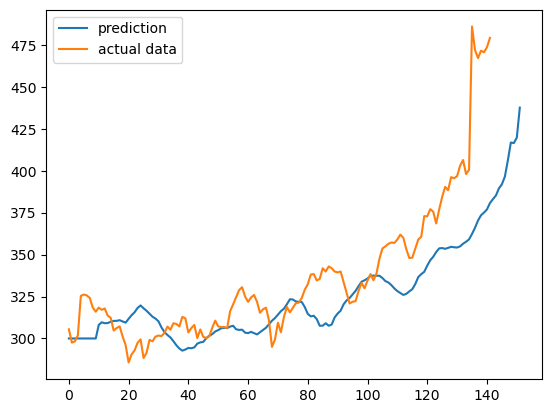

In [229]:

plt.plot([300,300,300,300,300, 300,300,300,300,300] +outputs, label = "prediction")
plt.plot(yyy_test, label="actual data")
plt.legend()
print(outputs)

[0.3326600193977356, -0.9415180683135986, -0.08906615525484085, 1.0671385526657104, -0.21197570860385895, -0.050187334418296814, 1.282227873802185, -0.5086533427238464, 0.9784912467002869, -0.6812365651130676]
[-0.23522406816482544, -0.17257535457611084, -0.08961544185876846, -0.2108260542154312, 0.4718262255191803, -0.27401238679885864, 0.058126065880060196, 0.13263055682182312, -0.19979751110076904, -0.0841212272644043]
tensor([6.5069, 6.7308, 6.9950, 7.0586, 7.2180], grad_fn=<SqueezeBackward0>)


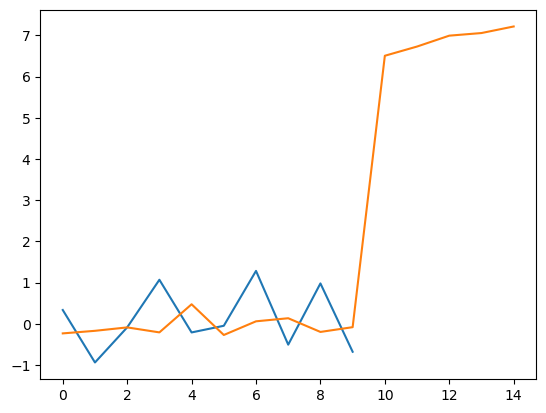

In [225]:
##Synthetic data
import matplotlib.pyplot as plt
inp_data = torch.randn(1, 1, backcast_length)
print(inp_data.squeeze().tolist())
backcast, forecast = model(inp_data)

print(backcast.squeeze().tolist())
print(forecast.squeeze())
bc = backcast.squeeze().tolist()
fc = forecast.squeeze().tolist()
pred = bc + fc

plt.plot(inp_data.squeeze().tolist())
plt.plot(pred)
